In [20]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
import calendar

import sys, warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
# warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [84]:
def calc_rnet(sd,ld,su,lu):             # Net radiation at surface [W/m**2]
    return sd+ld-su-lu

def calc_alb(dsw,usw):             # surface albedo [-]
    if dsw.all() != 0.:
        alb = usw/dsw
    else:
        alb = usw * np.nan
    return alb

def calc_kdepss(ref,mod):
    if np.std(ref) != 0 and np.std(mod) != 0:
        kde_ref = stats.gaussian_kde(ref)
        kde_mod = stats.gaussian_kde(mod)
        vmin = min([ref.min(), mod.min()])
        vmax = max([ref.max(), mod.max()])
        
        KDEnbins = 1000
        dx = ((vmax-vmin)*2/KDEnbins)
        ls = np.linspace(vmin-(vmax-vmin)/2, vmax+(vmax-vmin)/2, KDEnbins)
        
        arr = np.empty([2, KDEnbins])
        arr[:] = 0.
        arr[0,:] = kde_ref(ls)
        arr[1,:] = kde_mod(ls)
        del kde_ref
        del kde_mod
        kde_pss = np.sum(np.min(arr,axis=0))*dx
    else:
        kde_pss = np.nan
    
    return kde_pss

In [22]:
dir = '/homes/eseo8/python/UFS/FLUXNET/subset_subpt/DD/FULLSET/'
site_list = sorted(glob.glob(dir+'*_DD_QC.csv'))
# print(len(site_list))
# sys.exit()

pts = ["P5","P6","P7a","P7","P8a","P8at"]
dirs= ["/project/UFS_land/AWS/P5_hindcast/",
       "/project/UFS_land/AWS/P6_hindcast/",
       "/project/UFS_land/AWS/P7_hindcast/P7a_",
       "/project/UFS_land/AWS/P7_hindcast/",
       "/project/UFS_land/UFS_P8_hindcast/P8a/netcdf/P8a_",
       "/project/UFS_land/UFS_P8_hindcast/P8at/netcdf/P8at_"]
      

######################################################################
f_start = 0 ; f_stop = len(site_list)     # These files/sites [206 stations]
######################################################################

# data_save = ["TA_F","SW_IN_F","LW_IN_F","VPD_F","PA_F","P_F","WS_F","USTAR","NETRAD","SW_OUT","LW_OUT",
#              "CO2_F_MDS","TS_F_MDS_1","SWC_F_MDS_1","SWC_F_MDS_1","SWC_F_MDS_2","G_F_MDS","LE_F_MDS","H_F_MDS",
#              "EF_DV","ALB_DV","LCL_DV","QA_DV","ME_DV"]
target_vars = ["DSW","DLW","USW","ULW",
               "LH","SH","PR","QA","SSM",
               "ST","TA","Tmax","Tmin",
               "NETRAD","ALB"]

flux_vars = ["SW_IN_F","LW_IN_F","SW_OUT","LW_OUT",
             "LE_F_MDS","H_F_MDS","P_F","QA_DV","SWC_F_MDS_1",
             "TS_F_MDS_1","TA_F","TA_max","TA_min"]

ufs_vars = ["DSWRF.surface.6_hour_ave","DLWRF.surface.6_hour_ave","USWRF.surface.6_hour_ave","ULWRF.surface.6_hour_ave",
            "LHTFL.surface.6_hour_ave","SHTFL.surface.6_hour_ave","PRATE.surface.6_hour_ave","SPFH.2_m_above_ground","SOILW.0-0.1_m_below_ground",
            "TSOIL.0-0.1_m_below_ground","TMP.2_m_above_ground","TMAX.2_m_above_ground.6_hour_max","TMIN.2_m_above_ground.6_hour_min"]

years = [x for x in range(2012,2014)]
init_sub_dates = ["0101","0401","0701","1001"]
init_dates = [None] * len(years) * len(init_sub_dates)

cnt = 0
for yr in years:
    for id in init_sub_dates:
        init_dates[cnt] = str(yr)+id
        cnt = cnt + 1

print(init_dates)
comp = dict(zlib=True, complevel=1)

['20120101', '20120401', '20120701', '20121001', '20130101', '20130401', '20130701', '20131001']


In [23]:
obs = np.empty([len(flux_vars),len(init_dates),35,len(site_list)])
lon = np.empty([len(site_list)])
lat = np.empty([len(site_list)])
site = [None] * len(site_list)
igbp = [None] * len(site_list)
obs[:] = np.nan
lon[:] = np.nan
lat[:] = np.nan
print(obs.shape) #(13, 8, 35, 171)
# sys.exit()

# open FluxTowers
for ff,f in enumerate(site_list[f_start:f_stop]):
    # print (ff,f.split("/")[9])
    # f_siteid = f.split("/")[9].split("_")[0]
    # print(f_siteid)
    # sys.exit()
    df1 = pd.read_csv(f,na_values=-9999)
    # print(df1)
    # sys.exit()
    
    f_siteid = f.split("/")[9].split("DD")[0]
    f2 = sorted(glob.glob(dir+'/'+f_siteid+'site.csv'))
    # print(f2)
    # sys.exit()
    df2 = pd.read_csv(f2[0],sep=",")
    # print(df2)
    site[ff] = df2['Site ID'].item()
    lon[ff] = df2['Longitude'].item()
    lat[ff] = df2['Latitude'].item()
    igbp[ff] = df2['IGBP type'].item()
    
    # sys.exit()
    
    for i,id in enumerate(init_dates):
        time = str(pd.to_datetime(id))[:10]
        tloc = df1.loc[df1["time"] == time].index.item()
        
        for v,var in enumerate(flux_vars):
        
            obs[v,i,:,ff] = df1[var][tloc:tloc+35]
        del time
        del tloc
        

lon = np.where(lon<0.,lon+360.,lon) # lon=[-180~180] --> [0~360]
print("station lon=({}~{}), lat=({}~{})".format(lon.min(),lon.max(),lat.min(),lat.max()))
# sys.exit()

(13, 8, 35, 171)
station lon=(1.95191~357.30579), lat=(-37.4222~78.186)


In [24]:
ufs_dir = '/homes/eseo8/python/UFS/FLUXNET/subset_subpt/DD/data/'

# open UFS prototypes
for pp,p in enumerate(pts):

    # for v,vars in enumerate(ufs_vars[0:len(ufs_vars)-4]):
    for v,vars in enumerate(ufs_vars):
        # print(v,vars)
        
        for i,id in enumerate(init_dates):
            vfile = sorted(glob.glob(ufs_dir+p+'_'+id+'_'+vars+'.nc4'))
            # print(vfile)
            # sys.exit()
            if i == 0:
                vdata1 = xr.open_dataset(vfile[0])[vars]
            else:
                data = xr.open_dataset(vfile[0])[vars]
                vdata1 = xr.concat([vdata1, data], dim="init_dates")
                del data
            del vfile
        
        if v == 0:
            vdata2 = vdata1
            time = vdata2.time
        else:
            vv1 = vdata1.assign_coords({"time": (time)}) # time coordinate difference in temperature variables 
            vdata2 = xr.concat([vdata2, vv1], dim="variables")
            del vv1
        del vdata1
    
    if pp == 0:
        vdata3 = vdata2
    else:
        vdata3 = xr.concat([vdata3, vdata2], dim="prototypes")
    del vdata2

ufs = vdata3.copy(deep=True)
del vdata3
ufs

<xarray.DataArray 'DSWRF.surface.6_hour_ave' (prototypes: 6, variables: 13, init_dates: 8, time: 35, sites: 171)>
array([[[[[297.5       , 387.5       , 382.5       , ...,
           147.5       , 160.        ,  55.        ],
          [237.5       , 317.5       , 375.        , ...,
           147.5       , 162.5       ,  15.        ],
          [210.        , 297.5       , 255.        , ...,
           135.        , 160.        ,  55.        ],
          ...,
          [260.75      , 358.25      , 201.75      , ...,
           188.25      , 198.        ,  48.5       ],
          [218.25      , 202.25      , 312.75      , ...,
           188.75      , 198.25      ,  71.5       ],
          [ 93.        , 142.66667175,  85.33333588, ...,
           251.        , 248.33332825,  68.        ]],

         [[273.75      , 194.        , 216.5       , ...,
           313.5       , 313.75      ,  52.75      ],
          [270.25      , 223.        , 229.75      , ...,
           255.25      , 317.75      , 121.        ],
          [266.        , 200.75      , 224.75      , ...,
           263.75      , 312.75      ,  84.        ],
...
          [288.3999939 , 281.29998779, 285.29998779, ...,
           287.70001221, 291.5       , 284.70001221],
          [295.70001221, 284.3999939 , 284.1000061 , ...,
           290.5       , 293.1000061 , 285.1000061 ],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan]],

         [[286.70999146, 282.83999634, 282.77999878, ...,
           283.75      , 286.48999023, 277.86999512],
          [285.72000122, 281.3999939 , 285.39001465, ...,
           283.20001221, 285.98999023, 276.63000488],
          [282.67001343, 281.25      , 281.04000854, ...,
           282.95001221, 286.23999023, 275.89001465],
          ...,
          [295.63000488, 290.82998657, 292.47000122, ...,
           276.26998901, 279.07998657, 274.54000854],
          [295.41000366, 290.01998901, 296.52999878, ...,
           276.70999146, 278.58999634, 275.30999756],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan]]]]])
Coordinates:
  * time      (time) timedelta64[ns] 1 days 06:00:00 ... 35 days 06:00:00
    gaussian  int64 0
  * sites     (sites) object 'AU-ASM' 'AU-Cpr' 'AU-Cum' ... 'US-Wkg' 'US-Wrc'
    reftime   (init_dates) datetime64[ns] 2012-01-01 2012-04-01 ... 2013-10-01
    lon       (sites) float64 133.2 140.6 150.7 131.3 ... 254.1 250.1 238.0
    lat       (sites) float64 -22.28 -34.0 -33.62 -14.06 ... 34.43 31.74 45.82
Dimensions without coordinates: prototypes, variables, init_dates
Attributes:
    short_name:    DSWRF
    long_name:     Downward Short-Wave Radiation Flux
    units:         W/m^2
    grid_mapping:  gaussian

In [85]:
print(obs.shape) #(13, 8, 35, 99)
print(ufs.shape) #(6, 13, 8, 35, 99)

nbias = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon)])
nrmse = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon)])
rmse = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon)])
bias = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon)])
corr = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon)])
kpss = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon)])
samp = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon)])
samp_var = np.empty([len(init_sub_dates),len(lon)])
nbias[:] = np.nan
nrmse[:] = np.nan
rmse[:] = np.nan
bias[:] = np.nan
corr[:] = np.nan
kpss[:] = np.nan
samp[:] = np.nan
samp_var[:] = np.nan

for i,id in enumerate(init_sub_dates):
    for ff in range(len(lon)):
        cnt = 0.
        for v,var in enumerate(target_vars[:11]): # DSW, DLW, USW, ULW, LH, SH, PR, QA, SM, ST, TA
            obs2 = obs[v,i::4,:,ff].flatten()
            ufs2 = ufs[0,v,i::4,:,ff].values.flatten()
            mm = (~np.isnan(obs2)) & (~np.isnan(ufs2))
            if mm.sum() > 30:
                cnt = cnt+1
            del obs2
            del ufs2
        samp_var[i,ff] = cnt
                    

for i,id in enumerate(init_sub_dates):
    print(i,id)
    for v,var in enumerate(target_vars):
        for pp,p in enumerate(pts):
            
            cnt = 0.
            for ff in range(len(lon)):
                
                
                if var =="PR": # mm/day
                    obs2 = obs[v,i::4,:,ff].flatten()
                    ufs2 = (ufs[pp,v,i::4,:,ff]*86400.).values.flatten()
                elif ( var=="TA" or var=="ST" or var=="Tmax" or var=="Tmin" ):
                    obs2 = obs[v,i::4,:,ff].flatten() # K --> degC
                    ufs2 = (ufs[pp,v,i::4,:,ff]-273.15).values.flatten()
                elif ( var=="NETRAD" ):
                    obs2 = calc_rnet(obs[0,i::4,:,ff],obs[1,i::4,:,ff],obs[2,i::4,:,ff],obs[3,i::4,:,ff]).flatten()
                    ufs2 = calc_rnet(ufs[pp,0,i::4,:,ff],ufs[pp,1,i::4,:,ff],ufs[pp,2,i::4,:,ff],ufs[pp,3,i::4,:,ff]).values.flatten()
                elif ( var=="ALB" ):
                    obs2 = calc_alb(obs[0,i::4,:,ff], obs[2,i::4,:,ff]).flatten()
                    ufs2 = calc_alb(ufs[pp,0,i::4,:,ff], ufs[pp,2,i::4,:,ff]).values.flatten()
                elif ( target_vars[v]=="SSM" ): # m3/m3 --> %
                    obs2 = obs[v,i::4,:,ff].flatten()
                    ufs2 = (ufs[pp,v,i::4,:,ff]*100.).values.flatten()
                elif ( target_vars[v]=="QA" ): # kg/kg --> g/kg
                    obs2 = (obs[v,i::4,:,ff]*1000.).flatten()
                    ufs2 = (ufs[pp,v,i::4,:,ff]*1000.).values.flatten()
                else:
                    obs2 = obs[v,i::4,:,ff].flatten()
                    ufs2 = ufs[pp,v,i::4,:,ff].values.flatten()
                

                mm = (~np.isnan(obs2)) & (~np.isnan(ufs2))
                if mm.sum() > 30:
                    if np.std( obs2[mm] ) != 0.:
                        
                        bias[pp,v,i,ff] = np.mean(ufs2[mm]) - np.mean(obs2[mm])
                        corr[pp,v,i,ff] = stats.pearsonr(obs2[mm], ufs2[mm])[0]
                        kpss[pp,v,i,ff] = calc_kdepss(obs2[mm],ufs2[mm])
                        # rmse[pp,v,i,ff] = mean_squared_error(obs2[mm],ufs2[mm]) / float(mm.sum())
                        rmse[pp,v,i,ff] = np.sqrt( mean_squared_error(obs2[mm],ufs2[mm]) )
                        nbias[pp,v,i,ff] = bias[pp,v,i,ff] / np.std( obs2[mm] )
                        nrmse[pp,v,i,ff] = np.sqrt( mean_squared_error(obs2[mm]-np.mean(obs2[mm]),ufs2[mm]-np.mean(ufs2[mm])) ) / np.std( obs2[mm] )
                        # print(bias[pp,v,i,ff],nbias[pp,v,i,ff])
                        # print(rmse[pp,v,i,ff],nrmse[pp,v,i,ff])
                        # sys.exit()
                        samp[pp,v,i,ff] = 1
                    
            
            

(13, 8, 35, 171)
(6, 13, 8, 35, 171)
0 0101
1 0401
2 0701
3 1001


In [73]:
kde_ref = stats.gaussian_kde(aa)
kde_mod = stats.gaussian_kde(bb)
vmin = min([aa.min(), bb.min()])
vmax = max([aa.max(), bb.max()])

KDEnbins = 1000
dx = ((vmax-vmin)*2/KDEnbins)
ls = np.linspace(vmin-(vmax-vmin)/2, vmax+(vmax-vmin)/2, KDEnbins)
# print(ls)
print(kde_ref(ls).shape)
print(kde_mod(ls).dtype)
arr = np.empty([2, KDEnbins])
arr[:] = 0.
arr[0,:] = kde_ref(ls)
arr[1,:] = kde_mod(ls)
print(np.min(arr,axis=0).shape)
pss_kde = np.sum(np.min(arr,axis=0))*dx
pss_kde

(1000,)
float64
(1000,)


0.6322551261053596

0.31145745745745046
2.8986836491789774


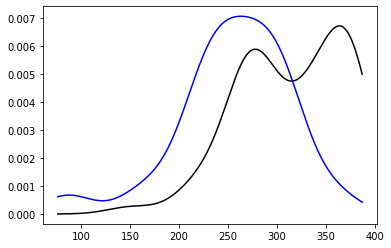

In [59]:
# plt.plot(aa)
# plt.plot(bb)

aa = obs2[mm]
bb = ufs2[mm]

kde_ref = stats.gaussian_kde(aa)
kde_mod = stats.gaussian_kde(bb)
print(kde_ref)
# kde_ref.plot()
# plt.plot(kde_ref)
# plt.plot(kde_mod)
# plt.show()
min1 = [aa.min(), bb.min()]
max1 = [aa.max(), bb.max()]

# kde = stats.gaussian_kde(y)
xx = np.linspace(np.min(min1), np.max(max1), 1000)
plt.plot(xx,kde_ref(xx),color='black')
plt.plot(xx,kde_mod(xx),color='blue')
pss = 0.
dx = xx[1]-xx[0]
print(dx)
print(kde_ref(xx).sum())

plt.show()

In [32]:
print(np.nanmin(nbias),np.nanmax(nbias))
print(np.nanmin(nrmse),np.nanmax(nrmse))
print(np.nanmin(bias),np.nanmax(bias))
print(np.nanmin(rmse),np.nanmax(rmse))

-81.94996173835248 544.6916814752389
0.32544503723750423 375.0874742547891
-210.93192400752477 238.01102698292453
0.0037682334152840517 259.47140687537666


In [33]:
# replace np.inf to np.nan
nbias = np.ma.masked_array(nbias, ~np.isfinite(nbias)).filled(np.nan)
nrmse = np.ma.masked_array(nrmse, ~np.isfinite(nrmse)).filled(np.nan)
print(np.nanmin(nbias),np.nanmax(nbias))
print(np.nanmin(nrmse),np.nanmax(nrmse))

-81.94996173835248 544.6916814752389
0.32544503723750423 375.0874742547891


1.0765669034579224 3.9976912412784498


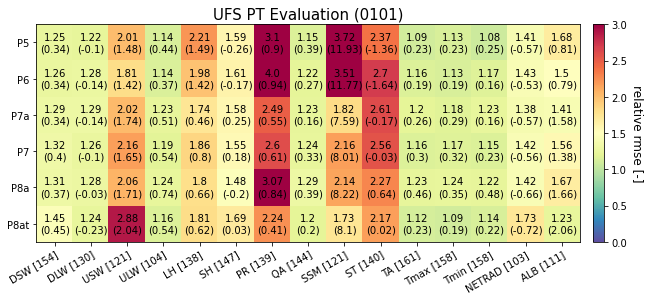

0.9892760049474021 3.134616951009036


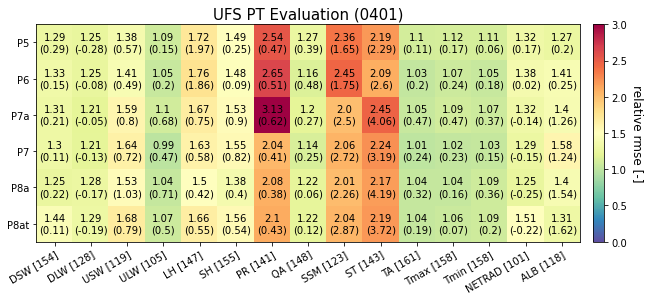

1.15822438274445 2.667167150999736


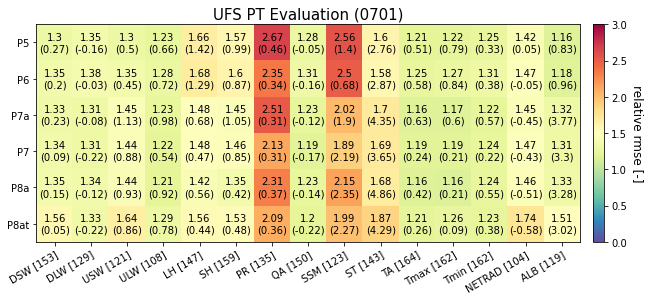

1.0921020167305229 9.494891639586148


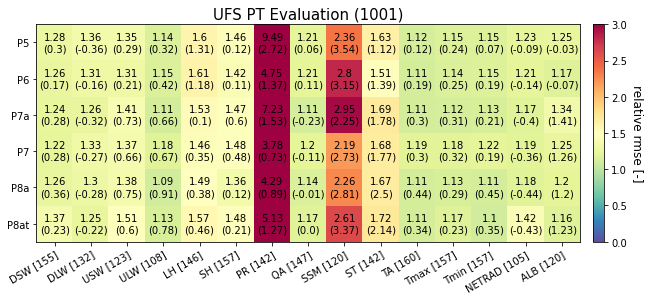

In [34]:
from sklearn import preprocessing
from scipy import special

vegetables = pts
farmers = target_vars
for i,id in enumerate(init_sub_dates):
    fname="./fig/UFS_rel_rmse_score_"+id+".png"
    harvest = np.nanmean(nrmse[:,:,i,:],axis=2) # [veg,farmer]
    bias2 = np.nanmean(nbias[:,:,i,:],axis=2) # [veg,farmer]
    samp2 = np.nansum(samp[0,:,i,:],axis=1)
    
    farmers2 = [farmers[x]+" ["+str(int(samp2[x]))+"]" for x in range(len(farmers))]
    
    harvest2 = np.nanmean(nrmse[:,:,i,:],axis=2)
    print(np.nanmin(harvest2),np.nanmax(harvest2))
    # plt.figure(figsize=(13,5))
    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    # im = ax.imshow(harvest2, cmap='bwr', vmin=-3, vmax=3)
    im = ax.imshow(harvest2, cmap='Spectral_r', vmin=0, vmax=3)
    # im = ax.imshow(harvest2, cmap='Spectral',vmin=0., vmax=1.)
    
    # Show all ticks and label them with the respective list entries
    # ax.set_xticks(np.arange(len(farmers)), labels=farmers)
    # ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
    ax.set_xticks(np.arange(len(farmers)))
    ax.set_yticks(np.arange(len(vegetables)))
    ax.set_xticklabels(farmers2)
    ax.set_yticklabels(vegetables)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, "{}\n({})".format(round(harvest[i, j],2),round(bias2[i, j],2)),
                           ha="center", va="center", color="k")
            # text = ax.text(j, i, r"\textcolor{red}{}".format(round(harvest[i, j],2)),
            #                ha="center", va="center")
    
    ax.set_title("UFS PT Evaluation ({})".format(id),fontsize=15)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, pad=0.02)
    cbar.ax.set_ylabel("relative rmse [-]", rotation=-90, va="bottom",fontsize=12)
    # cbar = ax.figure.colorbar(im, ax=ax, pad=0.02, orientation='horizontal')
    # cbar.ax.set_ylabel("standardized error across UFS_PTs [-]", va="center",fontsize=12)
        
    
   
    # fig.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
    plt.show()
    # sys.exit()

0.45984823445159095 4.043191177225327


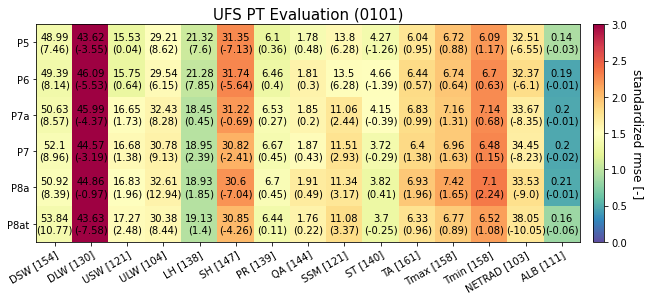

0.7768857433773301 3.6820445988941524


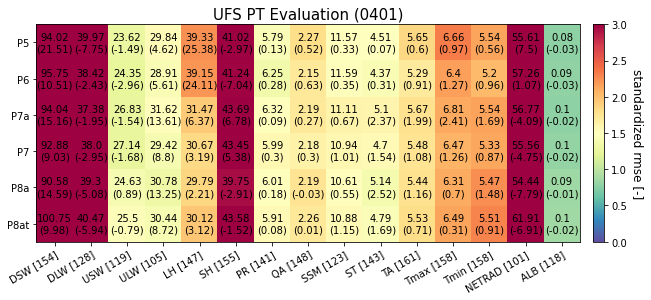

0.9205242471202353 3.948266283921586


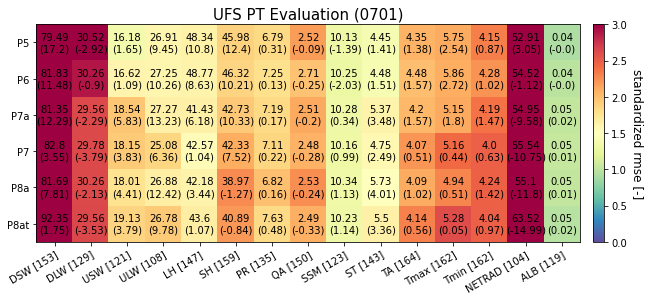

0.8049274299997496 3.3775577023469254


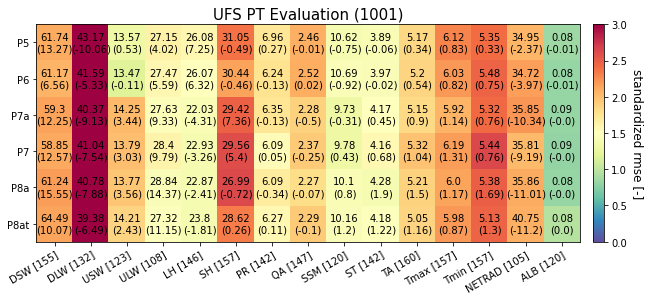

In [35]:
from sklearn import preprocessing
from scipy import special

vegetables = pts
farmers = target_vars
for i,id in enumerate(init_sub_dates):
    fname="./fig/UFS_stand_rmse_score_"+id+".png"
    harvest = np.nanmean(rmse[:,:,i,:],axis=2) # [veg,farmer]
    bias2 = np.nanmean(bias[:,:,i,:],axis=2) # [veg,farmer]
    samp2 = np.nansum(samp[0,:,i,:],axis=1)
    
    farmers2 = [farmers[x]+" ["+str(int(samp2[x]))+"]" for x in range(len(farmers))]
    
    # harvest2 = np.nanmean(nrmse[:,:,i,:],axis=2)
    harvest2 = np.nanmean(rmse[:,:,i,:],axis=2) / np.nanstd(rmse[:,:,i,:],axis=2)
    print(np.nanmin(harvest2),np.nanmax(harvest2))
    # plt.figure(figsize=(13,5))
    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    # im = ax.imshow(harvest2, cmap='bwr', vmin=-3, vmax=3)
    im = ax.imshow(harvest2, cmap='Spectral_r', vmin=0, vmax=3)
    # im = ax.imshow(harvest2, cmap='Spectral',vmin=0., vmax=1.)
    
    # Show all ticks and label them with the respective list entries
    # ax.set_xticks(np.arange(len(farmers)), labels=farmers)
    # ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
    ax.set_xticks(np.arange(len(farmers)))
    ax.set_yticks(np.arange(len(vegetables)))
    ax.set_xticklabels(farmers2)
    ax.set_yticklabels(vegetables)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, "{}\n({})".format(round(harvest[i, j],2),round(bias2[i, j],2)),
                           ha="center", va="center", color="k")
            # text = ax.text(j, i, r"\textcolor{red}{}".format(round(harvest[i, j],2)),
            #                ha="center", va="center")
    
    ax.set_title("UFS PT Evaluation ({})".format(id),fontsize=15)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, pad=0.02)
    cbar.ax.set_ylabel("standardized rmse [-]", rotation=-90, va="bottom",fontsize=12)
    # cbar = ax.figure.colorbar(im, ax=ax, pad=0.02, orientation='horizontal')
    # cbar.ax.set_ylabel("standardized error across UFS_PTs [-]", va="center",fontsize=12)
        
    
   
    # fig.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
    plt.show()
    # sys.exit()

-1.6374079782426065 11.933255209335945


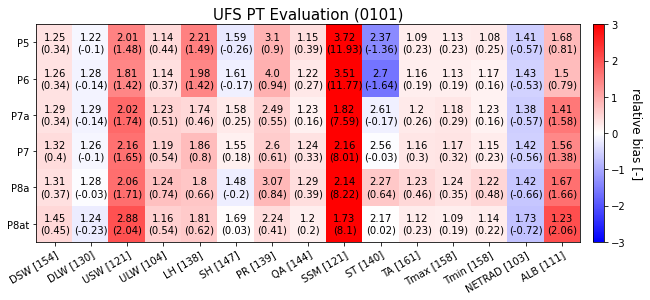

-0.28303300564506906 4.186984373137419


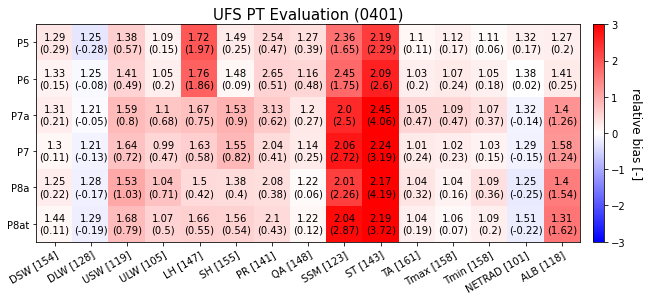

-0.5756868983181044 4.855310159458908


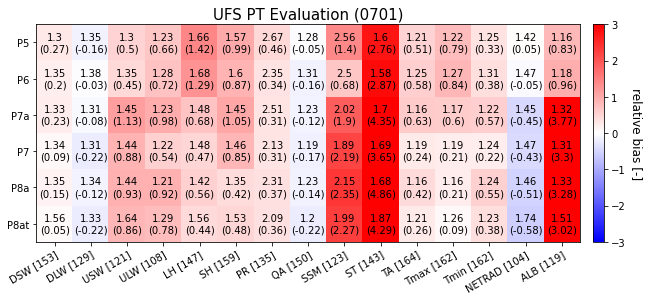

-0.4363479414474725 3.541729328734453


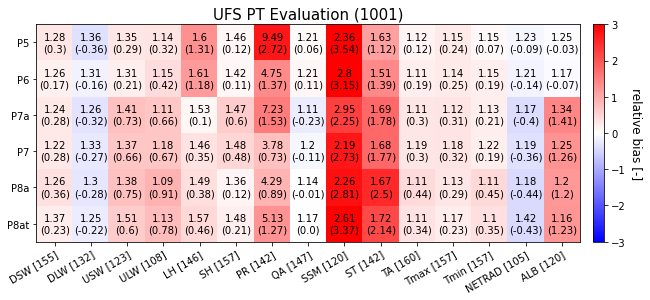

In [36]:
from sklearn import preprocessing
from scipy import special

vegetables = pts
farmers = target_vars
for i,id in enumerate(init_sub_dates):
    fname="./fig/UFS_rel_bias_score_"+id+".png"
    harvest = np.nanmean(nrmse[:,:,i,:],axis=2) # [veg,farmer]
    bias2 = np.nanmean(nbias[:,:,i,:],axis=2) # [veg,farmer]
    samp2 = np.nansum(samp[0,:,i,:],axis=1)
    
    farmers2 = [farmers[x]+" ["+str(int(samp2[x]))+"]" for x in range(len(farmers))]
    
    harvest2 = np.nanmean(nbias[:,:,i,:],axis=2)
    # harvest2 = np.nanmean(bias[:,:,i,:],axis=2) / np.nanstd(bias[:,:,i,:],axis=2)
    print(np.nanmin(harvest2),np.nanmax(harvest2))
    # plt.figure(figsize=(13,5))
    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    im = ax.imshow(harvest2, cmap='bwr', vmin=-3, vmax=3)
    # im = ax.imshow(harvest2, cmap='Spectral',vmin=0., vmax=1.)
    
    # Show all ticks and label them with the respective list entries
    # ax.set_xticks(np.arange(len(farmers)), labels=farmers)
    # ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
    ax.set_xticks(np.arange(len(farmers)))
    ax.set_yticks(np.arange(len(vegetables)))
    ax.set_xticklabels(farmers2)
    ax.set_yticklabels(vegetables)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, "{}\n({})".format(round(harvest[i, j],2),round(bias2[i, j],2)),
                           ha="center", va="center", color="k")
            # text = ax.text(j, i, r"\textcolor{red}{}".format(round(harvest[i, j],2)),
            #                ha="center", va="center")
    
    ax.set_title("UFS PT Evaluation ({})".format(id),fontsize=15)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, pad=0.02)
    cbar.ax.set_ylabel("relative bias [-]", rotation=-90, va="bottom",fontsize=12)
    # cbar = ax.figure.colorbar(im, ax=ax, pad=0.02, orientation='horizontal')
    # cbar.ax.set_ylabel("standardized error across UFS_PTs [-]", va="center",fontsize=12)
        
    
   
    # fig.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
    plt.show()
    # sys.exit()

-0.42167864710327746 0.6102808987186201


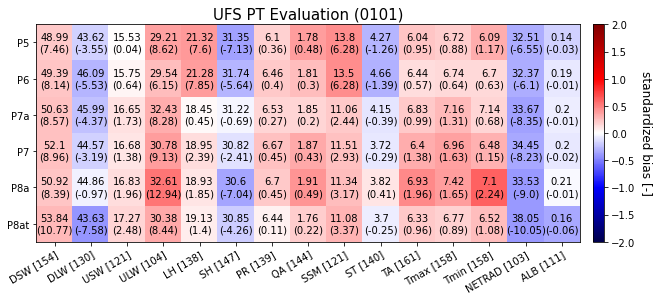

-0.37331079815749135 1.2772215107601341


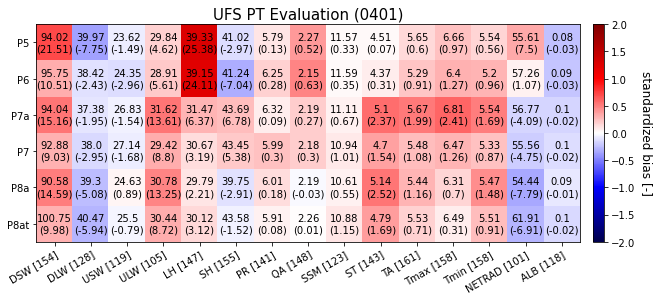

-0.6729803390598191 0.8178436911681991


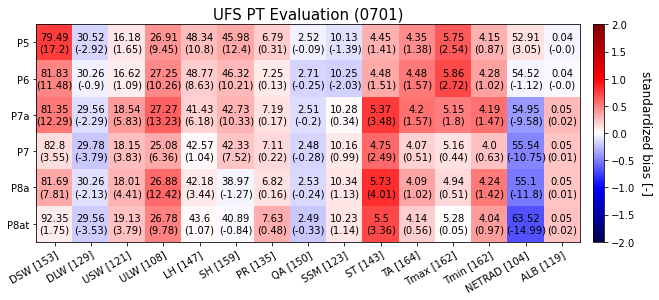

-0.5290318681887451 0.6136044968053018


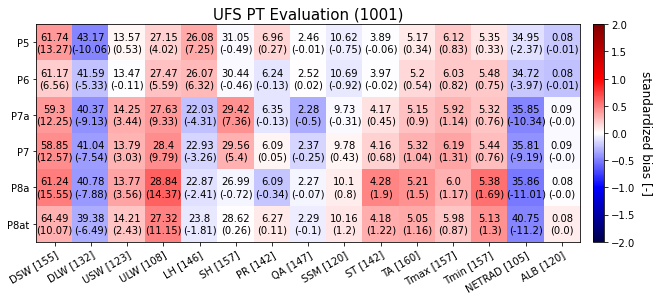

SystemExit: 

In [37]:
from sklearn import preprocessing
from scipy import special

vegetables = pts
farmers = target_vars
for i,id in enumerate(init_sub_dates):
    fname="./fig/UFS_stand_bias_score_"+id+".png"
    harvest = np.nanmean(rmse[:,:,i,:],axis=2) # [veg,farmer]
    bias2 = np.nanmean(bias[:,:,i,:],axis=2) # [veg,farmer]
    samp2 = np.nansum(samp[0,:,i,:],axis=1)
    
    farmers2 = [farmers[x]+" ["+str(int(samp2[x]))+"]" for x in range(len(farmers))]
    
    # harvest2 = np.nanmean(nbias[:,:,i,:],axis=2)
    harvest2 = np.nanmean(bias[:,:,i,:],axis=2) / np.nanstd(bias[:,:,i,:],axis=2)
    print(np.nanmin(harvest2),np.nanmax(harvest2))
    # plt.figure(figsize=(13,5))
    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    im = ax.imshow(harvest2, cmap='seismic', vmin=-2, vmax=2)
    # im = ax.imshow(harvest2, cmap='Spectral',vmin=0., vmax=1.)
    
    # Show all ticks and label them with the respective list entries
    # ax.set_xticks(np.arange(len(farmers)), labels=farmers)
    # ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
    ax.set_xticks(np.arange(len(farmers)))
    ax.set_yticks(np.arange(len(vegetables)))
    ax.set_xticklabels(farmers2)
    ax.set_yticklabels(vegetables)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, "{}\n({})".format(round(harvest[i, j],2),round(bias2[i, j],2)),
                           ha="center", va="center", color="k")
            # text = ax.text(j, i, r"\textcolor{red}{}".format(round(harvest[i, j],2)),
            #                ha="center", va="center")
    
    ax.set_title("UFS PT Evaluation ({})".format(id),fontsize=15)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, pad=0.02)
    cbar.ax.set_ylabel("standardized bias [-]", rotation=-90, va="bottom",fontsize=12)
    # cbar = ax.figure.colorbar(im, ax=ax, pad=0.02, orientation='horizontal')
    # cbar.ax.set_ylabel("standardized error across UFS_PTs [-]", va="center",fontsize=12)
        
    # fig.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
    plt.show()
# sys.exit()

0.05153309765275015 0.30024046507179164


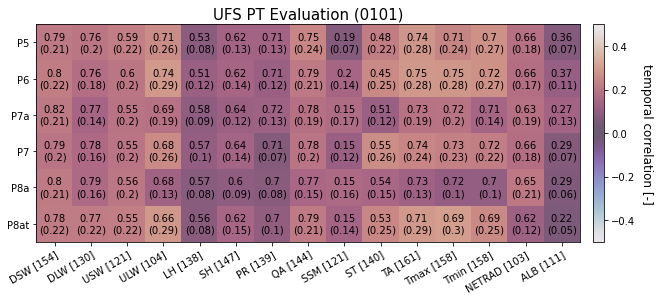

0.08465113575511252 0.5452389790337665


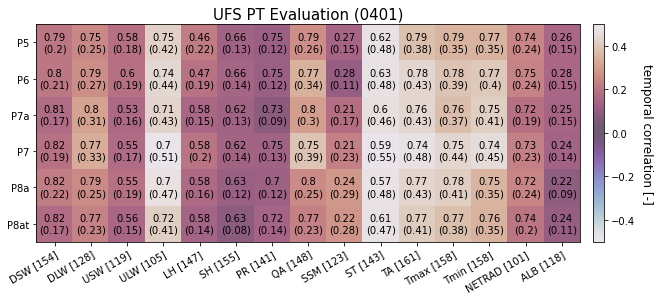

0.03095467319247149 0.32514185623678077


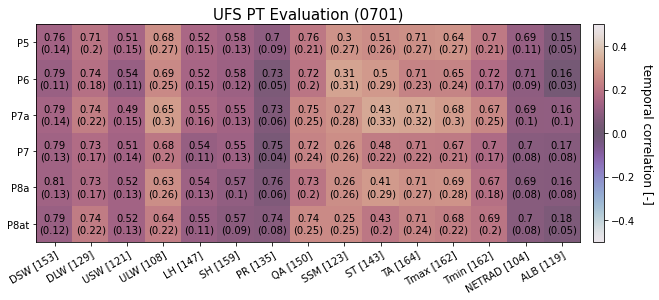

0.0061640138265434095 0.5243851647022452


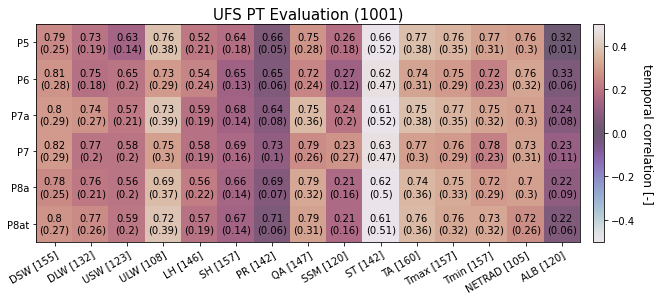

SystemExit: 

In [93]:
from sklearn import preprocessing
from scipy import special

vegetables = pts
farmers = target_vars
for i,id in enumerate(init_sub_dates):
    fname="./fig/UFS_corr_score_"+id+".png"
    harvest = np.nanmean(kpss[:,:,i,:],axis=2) # [veg,farmer]
    bias2 = np.nanmean(corr[:,:,i,:],axis=2) # [veg,farmer]
    samp2 = np.nansum(samp[0,:,i,:],axis=1)
    
    farmers2 = [farmers[x]+" ["+str(int(samp2[x]))+"]" for x in range(len(farmers))]
    
    harvest2 = np.nanmean(corr[:,:,i,:],axis=2)
    # harvest2 = np.nanmean(corr[:,:,i,:],axis=2) / np.nanstd(corr[:,:,i,:],axis=2)
    print(np.nanmin(harvest2),np.nanmax(harvest2))
    # plt.figure(figsize=(13,5))
    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    im = ax.imshow(harvest2, cmap='twilight', vmin=-0.5, vmax=0.5, alpha=0.7)
    # im = ax.imshow(harvest2, cmap='Spectral',vmin=0., vmax=1.)
    
    # Show all ticks and label them with the respective list entries
    # ax.set_xticks(np.arange(len(farmers)), labels=farmers)
    # ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
    ax.set_xticks(np.arange(len(farmers)))
    ax.set_yticks(np.arange(len(vegetables)))
    ax.set_xticklabels(farmers2)
    ax.set_yticklabels(vegetables)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, "{}\n({})".format(round(harvest[i, j],2),round(bias2[i, j],2)),
                           ha="center", va="center", color="k")
            # text = ax.text(j, i, r"\textcolor{red}{}".format(round(harvest[i, j],2)),
            #                ha="center", va="center")
    
    ax.set_title("UFS PT Evaluation ({})".format(id),fontsize=15)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, pad=0.02)
    cbar.ax.set_ylabel("temporal correlation [-]", rotation=-90, va="bottom",fontsize=12)
    # cbar = ax.figure.colorbar(im, ax=ax, pad=0.02, orientation='horizontal')
    # cbar.ax.set_ylabel("standardized error across UFS_PTs [-]", va="center",fontsize=12)
        
    # fig.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
    plt.show()
sys.exit()

0.1456518969330833 0.816919812559219


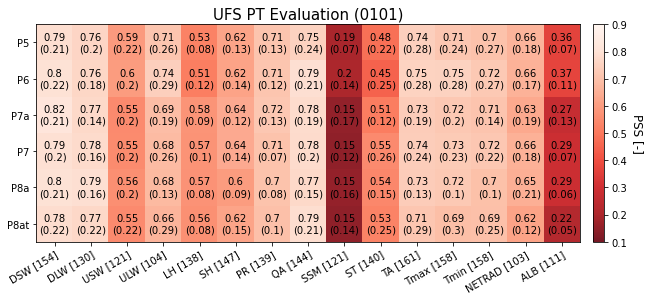

0.20810663143498312 0.8204685004982921


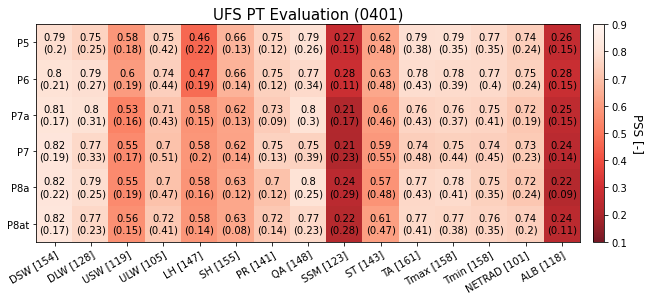

0.14915884337281432 0.8061295428238431


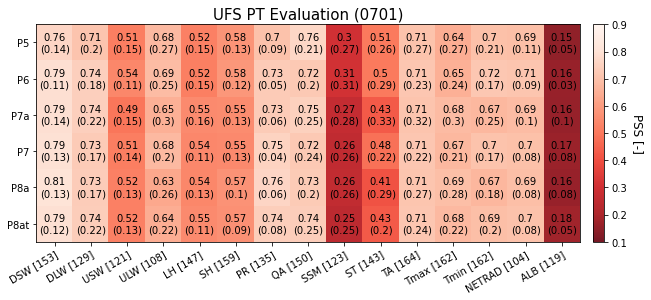

0.20902193422395848 0.8168500961360602


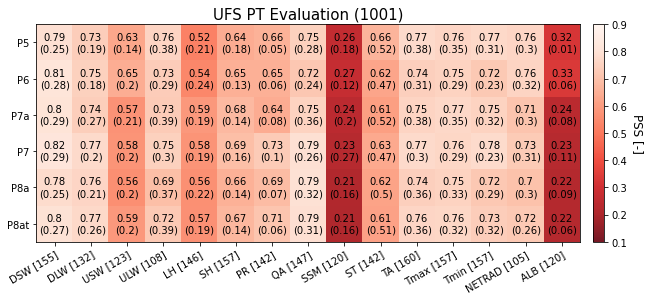

SystemExit: 

In [95]:
from sklearn import preprocessing
from scipy import special

vegetables = pts
farmers = target_vars
for i,id in enumerate(init_sub_dates):
    fname="./fig/UFS_kpss_score_"+id+".png"
    harvest = np.nanmean(kpss[:,:,i,:],axis=2) # [veg,farmer]
    bias2 = np.nanmean(corr[:,:,i,:],axis=2) # [veg,farmer]
    samp2 = np.nansum(samp[0,:,i,:],axis=1)
    
    farmers2 = [farmers[x]+" ["+str(int(samp2[x]))+"]" for x in range(len(farmers))]
    
    harvest2 = np.nanmean(kpss[:,:,i,:],axis=2)
    # harvest2 = np.nanmean(corr[:,:,i,:],axis=2) / np.nanstd(corr[:,:,i,:],axis=2)
    print(np.nanmin(harvest2),np.nanmax(harvest2))
    # plt.figure(figsize=(13,5))
    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    im = ax.imshow(harvest2, cmap='Reds_r', vmin=0.1, vmax=0.9, alpha=0.9)
    # im = ax.imshow(harvest2, cmap='Spectral',vmin=0., vmax=1.)
    
    # Show all ticks and label them with the respective list entries
    # ax.set_xticks(np.arange(len(farmers)), labels=farmers)
    # ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
    ax.set_xticks(np.arange(len(farmers)))
    ax.set_yticks(np.arange(len(vegetables)))
    ax.set_xticklabels(farmers2)
    ax.set_yticklabels(vegetables)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, "{}\n({})".format(round(harvest[i, j],2),round(bias2[i, j],2)),
                           ha="center", va="center", color="k")
            # text = ax.text(j, i, r"\textcolor{red}{}".format(round(harvest[i, j],2)),
            #                ha="center", va="center")
    
    ax.set_title("UFS PT Evaluation ({})".format(id),fontsize=15)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, pad=0.02)
    cbar.ax.set_ylabel("PSS [-]", rotation=-90, va="bottom",fontsize=12)
    # cbar = ax.figure.colorbar(im, ax=ax, pad=0.02, orientation='horizontal')
    # cbar.ax.set_ylabel("standardized error across UFS_PTs [-]", va="center",fontsize=12)
        
    # fig.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
    plt.show()
sys.exit()

In [ ]:
print(bias.shape)
print(samp.shape)
# print(samp[0,0,0,:])
# sys.exit()

# --- Build Map ---
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable


lon2 = np.where(lon>180.,lon-360.,lon) # lon=[0-360] --> [-180~180]
frac = 0.03
padp = 0.01
msize = 70

for pp,p in enumerate(pts):
    for ii,id in enumerate(init_sub_dates):
        fig = plt.figure(figsize=(15,21))
        fname="./fig/UFS_score_map_"+p+"_"+id+".png"
        ax = fig.add_subplot(7,2,1)
        tvar = target_vars[0]
        ssum = np.nansum(samp[pp,0,ii,:])
        val = bias[pp,0,ii,:] 
        val2 = rmse[pp,0,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,2)
        tvar = target_vars[1]
        ssum = np.nansum(samp[pp,1,ii,:])
        val = bias[pp,1,ii,:] 
        val2 = rmse[pp,1,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,3)
        tvar = target_vars[2]
        ssum = np.nansum(samp[pp,2,ii,:])
        val = bias[pp,2,ii,:] 
        val2 = rmse[pp,2,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,4)
        tvar = target_vars[3]
        ssum = np.nansum(samp[pp,3,ii,:])
        val = bias[pp,3,ii,:] 
        val2 = rmse[pp,3,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,5)
        tvar = target_vars[4]
        ssum = np.nansum(samp[pp,4,ii,:])
        val = bias[pp,4,ii,:]
        val2 = rmse[pp,4,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,6)
        tvar = target_vars[5]
        ssum = np.nansum(samp[pp,5,ii,:])
        val = bias[pp,5,ii,:] 
        val2 = rmse[pp,5,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,7)
        tvar = target_vars[6]
        ssum = np.nansum(samp[pp,6,ii,:])
        val = bias[pp,6,ii,:] 
        val2 = rmse[pp,6,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,8)
        tvar = target_vars[7]
        ssum = np.nansum(samp[pp,7,ii,:])
        val = bias[pp,7,ii,:] 
        val2 = rmse[pp,7,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,9)
        tvar = target_vars[8]
        ssum = np.nansum(samp[pp,8,ii,:])
        val = bias[pp,8,ii,:] 
        val2 = rmse[pp,8,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,10)
        tvar = target_vars[9]
        ssum = np.nansum(samp[pp,9,ii,:])
        val = bias[pp,9,ii,:] 
        val2 = rmse[pp,9,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,11)
        tvar = target_vars[10]
        ssum = np.nansum(samp[pp,10,ii,:])
        val = bias[pp,10,ii,:] 
        val2 = rmse[pp,10,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,12)
        tvar = target_vars[11]
        ssum = np.nansum(samp[pp,11,ii,:])
        val = bias[pp,11,ii,:] 
        val2 = rmse[pp,11,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)

        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(7,2,13)
        tvar = target_vars[12]
        ssum = np.nansum(samp[pp,12,ii,:])
        val = bias[pp,12,ii,:] 
        val2 = rmse[pp,12,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)        

        ax = fig.add_subplot(7,2,14)
        tvar = target_vars[13]
        ssum = np.nansum(samp[pp,13,ii,:])
        val = bias[pp,13,ii,:] 
        val2 = rmse[pp,13,ii,:] 

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(np.nanmean(val2)*(-1),np.nanmean(val2))
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        fig.tight_layout()
        
        plt.suptitle("Bias map of {} ({})".format(p,id),y=1.0,fontsize=15)
        plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
       
        

In [ ]:
print(bias.shape)
print(samp.shape)
# print(samp[0,0,0,:])
# sys.exit()

# --- Build Map ---
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable


lon2 = np.where(lon>180.,lon-360.,lon) # lon=[0-360] --> [-180~180]
frac = 0.03
padp = 0.01
msize = 70

# for pp,p in enumerate(pts):
for pp,p in enumerate(target_vars):
    for ii,id in enumerate(init_sub_dates):
        fig = plt.figure(figsize=(15,10))
        fname="./fig/UFS_score_map_"+p+"_"+id+".png"
        ax = fig.add_subplot(3,2,1)
        tvar = pts[0]
        ssum = np.nansum(samp[0,pp,ii,:])
        val = bias[0,pp,ii,:]
        val2 = rmse[0,pp,ii,:]
        clim = [np.nanmean(val2)*(-1), np.nanmean(val2)]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(clim)
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(3,2,2)
        tvar = pts[1]
        ssum = np.nansum(samp[1,pp,ii,:])
        val = bias[1,pp,ii,:]
        val2 = rmse[1,pp,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(clim)
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(3,2,3)
        tvar = pts[2]
        ssum = np.nansum(samp[2,pp,ii,:])
        val = bias[2,pp,ii,:]
        val2 = rmse[2,pp,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(clim)
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(3,2,4)
        tvar = pts[3]
        ssum = np.nansum(samp[3,pp,ii,:])
        val = bias[3,pp,ii,:]
        val2 = rmse[3,pp,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(clim)
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(3,2,5)
        tvar = pts[4]
        ssum = np.nansum(samp[4,pp,ii,:])
        val = bias[4,pp,ii,:]
        val2 = rmse[4,pp,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(clim)
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        ax = fig.add_subplot(3,2,6)
        tvar = pts[5]
        ssum = np.nansum(samp[5,pp,ii,:])
        val = bias[5,pp,ii,:]
        val2 = rmse[5,pp,ii,:]

        ax.set_title("{} [{}]".format(tvar,int(ssum)),fontsize=12)
        map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
                      llcrnrlon=lon2.min()-5, llcrnrlat=lat.min()-5, urcrnrlon=lon2.max()+5, urcrnrlat=lat.max()+5)
        map.drawcoastlines()
        map.drawcountries()
        # map.drawstates()
        # map.fillcontinents(color = 'gray')
        map.drawmapboundary()
        # map.drawmeridians(np.arange(0, 360, 30))
        # map.drawparallels(np.arange(-90, 90, 30))
        map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
        map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
        
        mask = ( ~np.isnan(val) )
        im = map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                    c= val[mask], cmap='seismic', s=msize, edgecolors='black', alpha=0.6)
        plt.clim(clim)
        # plt.colorbar(im,fraction=frac, pad=padp)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        ax.annotate('Bias={}\nRMSE={}'
                    .format(round(np.nanmean(val),2),round(np.nanmean(val2),2)),
                    xy=(0.05, 0.25), xycoords='axes fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=12)
        
        fig.tight_layout()
        
        plt.suptitle("Bias map of {} ({})".format(p,id),y=1.0,fontsize=15)
        plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
        # sys.exit()
       
        

In [ ]:
# --- Build Map ---
from mpl_toolkits.basemap import Basemap

lon2 = np.where(lon>180.,lon-360.,lon) # lon=[0-360] --> [-180~180]

for i,id in enumerate(init_sub_dates):
    fname="./fig/UFS_FluxTowers_map_"+id+".png"
    val = samp_var[i,:] # DSW, DLW, USW, ULW, LH, SH, PR, SM, ST, TA
    
    
    # Make this plot larger.
    plt.figure(figsize=(13,4.5))
    
    # map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0,
    #               lat_0=0, lon_0=-130)
    map = Basemap(projection='cyl', resolution = 'l', area_thresh = 1000.0,
    #               llcrnrlon=-130, llcrnrlat=25, urcrnrlon=-70, urcrnrlat=50)
                  llcrnrlon=lon2.min()-1.5, llcrnrlat=lat.min()-1.5, urcrnrlon=lon2.max()+1.5, urcrnrlat=lat.max()+1.5)
                  # llcrnrlon=lons1.min()-1.5, llcrnrlat=25, urcrnrlon=lons1.max(), urcrnrlat=lats1.max()+1.5)
    
    map.drawcoastlines()
    map.drawcountries()
    map.drawstates()
    # map.fillcontinents(color = 'gray')
    map.drawmapboundary()
    # map.drawmeridians(np.arange(0, 360, 30))
    # map.drawparallels(np.arange(-90, 90, 30))
    map.drawmeridians(np.arange(-180, 180, 60),labels=[0,0,0,1], fontsize=8) # labels=[left,right,upper,bottom]
    map.drawparallels(np.arange(-90, 90, 30),labels=[1,0,0,0], fontsize=8)
    
    mask = ( ~np.isnan(val) )
    map.scatter(lon2[mask], lat[mask], latlon=True, marker='o',
                c= val[mask], cmap='Spectral_r', s=100, edgecolors='black', alpha=0.6)
    plt.clim(1.,9.)

    
    plt.colorbar(orientation='vertical', pad=0.02)
    # plt.colorbar(orientation='horizontal', pad=0.02)
    
    mask = (~np.isnan(val))
    plt.title("FluxTowers ({}) [{}]".format(id,mask.sum()),fontsize=17)
    
    # title_string = "Earthquakes of Magnitude 1.0 or Greater\n"
    # title_string += "%s through %s" % (timestrings[-1][:10], timestrings[0][:10])
    # plt.title(title_string)
    # plt.savefig(fname)
    
    plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()

In [ ]:
vtd1 = xr.open_dataset('/project/UFS_land/AWS/P6_fixed/VGTYP.surface.nc4')
vtd2 = xr.open_dataset('/project/UFS_land/UFS_P7_hindcast/pt7_vegsoil.nc')

tt1 = vtd1['VGTYP.surface'].sel(longitude=265, latitude=42, method="nearest")
tt2 = vtd2['vegetation_type'].sel(lon=265, lat=42, method="nearest")
print(tt1)
print(tt2)

In [ ]:
# vegetation 
len(igbp)
# vt1 = xr.open_dataset('/project/UFS_land/AWS/P6_fixed/VGTYP.surface.nc4')['VGTYP.surface'].sel(longitude=lon, latitude=lat, method="nearest")
# vt2 = xr.open_dataset('/project/UFS_land/UFS_P7_hindcast/pt7_vegsoil.nc')['vegetation_type'].sel(lon=lon, lat=lat, method="nearest")
vtd1 = xr.open_dataset('/project/UFS_land/AWS/P6_fixed/VGTYP.surface.nc4')
vtd2 = xr.open_dataset('/project/UFS_land/UFS_P7_hindcast/pt7_vegsoil.nc')

vt1 = vtd1['VGTYP.surface'].sel(longitude=lon, latitude=lat, method="nearest")
vt2 = vtd2['vegetation_type'].sel(lon=lon, lat=lat, method="nearest")
print(vt1)
print(vt2)

In [ ]:
vg1 = vt1[0,:].rename({'longitude': 'sites'}).copy(deep=True)
vg2 = vt2[0,:].rename({'lon': 'sites'}).copy(deep=True)
vg1[:] = np.nan
vg1.coords['sites'] = site
vg2[:] = np.nan
vg2.coords['sites'] = site

del vg1.coords['latitude']
del vg2.coords['lat']

for ff in range(len(lon)):
    vg1[ff] = vt1[ff,ff]
    vg2[ff] = vt2[ff,ff]
    
# del vt1
# del vt2

vg1 = vg1.assign_coords({"lon": ("sites", lon)})
vg1 = vg1.assign_coords({"lat": ("sites", lat)})
vg2 = vg2.assign_coords({"lon": ("sites", lon)})
vg2 = vg2.assign_coords({"lat": ("sites", lat)})

veg_cat = ['WAT',
           'ENF','EBF','DNF','DBF','MF',
           'CSH','OSH',
           'WSA','SAV',
           'GRA',
           'WET',
           'CRO','URB','CVM','SNO','BSV','WAT','WT','MT','BT']

vgc1 = [veg_cat[int(x)] for x in vg1]
vgc2 = [veg_cat[int(x)] for x in vg2]


# Create DataFrame.
df = pd.DataFrame({'obs': igbp, 'vt1':vgc1, 'vt2':vgc2})

# aa = [i for i, j in zip(vgc1, igbp) if i == j]
mask1 = (df['obs']==df['vt1'])
mask2 = (df['obs']==df['vt2'])

In [ ]:
if p=='P5' or p=='P6':
    mask = mask1
else:
    mask = mask2

In [ ]:
rmse.shape
samp.shape

In [ ]:
from sklearn import preprocessing
from scipy import special

vegetables = pts
farmers = target_vars
for i,id in enumerate(init_sub_dates):
    fname="./fig/UFS_score_veg_"+id+".png"
    harvest = np.empty(np.nanmean(rmse[:,:,i,:],axis=2).shape)
    harvest2 = np.empty(np.nanmean(rmse[:,:,i,:],axis=2).shape)
    bias2 = np.empty(np.nanmean(rmse[:,:,i,:],axis=2).shape)
    samp2 = np.empty(np.nanmean(rmse[:,:,i,:],axis=2).shape)
    
    for pp,p in enumerate(pts):
        if p=='P5' or p=='P6':
            mask = mask1
        else:
            mask = mask2
        harvest[pp,:] = np.nanmean(rmse[pp,:,i,mask],axis=0)
        harvest2[pp,:] = np.nanmean(nbias[pp,:,i,mask],axis=0)
        bias2[pp,:] = np.nanmean(bias[pp,:,i,mask],axis=0)
        samp2[pp,:] = np.nansum(samp[pp,:,i,mask],axis=0)
    
    
    farmers2 = [farmers[x]+" ["+str(int(samp2[0,x]))+"/"+str(int(samp2[4,x]))+"]" for x in range(len(farmers))]
    
    harvest2 = np.nanmean(nbias[:,:,i,:],axis=2)
    print(np.nanmin(harvest2),np.nanmax(harvest2))
    # plt.figure(figsize=(13,5))
    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    im = ax.imshow(harvest2, cmap='bwr', vmin=-3, vmax=3)
    # im = ax.imshow(harvest2, cmap='Spectral',vmin=0., vmax=1.)
    
    # Show all ticks and label them with the respective list entries
    # ax.set_xticks(np.arange(len(farmers)), labels=farmers)
    # ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
    ax.set_xticks(np.arange(len(farmers)))
    ax.set_yticks(np.arange(len(vegetables)))
    ax.set_xticklabels(farmers2)
    ax.set_yticklabels(vegetables)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, "{}\n({})".format(round(harvest[i, j],2),round(bias2[i, j],2)),
                           ha="center", va="center", color="k")
            # text = ax.text(j, i, r"\textcolor{red}{}".format(round(harvest[i, j],2)),
            #                ha="center", va="center")
    
    ax.set_title("UFS PT Scores ({})".format(id),fontsize=15)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, pad=0.02)
    cbar.ax.set_ylabel("Standardized bias across PTs [-]", rotation=-90, va="bottom",fontsize=12)
    # cbar = ax.figure.colorbar(im, ax=ax, pad=0.02, orientation='horizontal')
    # cbar.ax.set_ylabel("standardized error across UFS_PTs [-]", va="center",fontsize=12)
        
    
   
    # fig.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
    plt.show()
    # sys.exit()

In [ ]:
print(obs.shape) #(11, 8, 35, 99)
print(ufs.shape) #(6, 11, 8, 35, 99)

nbias_wk = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon),4])
nrmse_wk = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon),4])
rmse_wk = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon),4])
bias_wk = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon),4])
samp_wk = np.empty([len(pts),len(target_vars),len(init_sub_dates),len(lon),4])
samp_var_wk = np.empty([len(init_sub_dates),len(lon),4])
nbias_wk[:] = np.nan
nrmse_wk[:] = np.nan
rmse_wk[:] = np.nan
bias_wk[:] = np.nan
samp_wk[:] = np.nan
samp_var_wk[:] = np.nan

for i,id in enumerate(init_sub_dates):
    for ff in range(len(lon)):
        for w in range(4):
            cnt = 0.
            for v,var in enumerate(target_vars[:10]): # DSW, DLW, USW, ULW, LH, SH, PR, SM, ST, TA
                obs2 = obs[v,i::4,w*7:(w+1)*7,ff].flatten()
                ufs2 = ufs[0,v,i::4,w*7:(w+1)*7,ff].values.flatten()
                mm = (~np.isnan(obs2)) & (~np.isnan(ufs2))
                if mm.sum() > 7:
                    cnt = cnt+1
                del obs2
                del ufs2
                del mm
            samp_var_wk[i,ff,w] = cnt
                    

for i,id in enumerate(init_sub_dates):
    
    for v,var in enumerate(target_vars):
        print(id, var)
        for pp,p in enumerate(pts):
            for w in range(4):
            
                for ff in range(len(lon)):
                    
                    
                    if var =="PR":
                        obs2 = obs[v,i::4,w*7:(w+1)*7,ff].flatten()
                        ufs2 = (ufs[pp,v,i::4,w*7:(w+1)*7,ff]*86400.).values.flatten()
                    elif ( var=="TA" or var=="ST" or var=="Tmax" or var=="Tmin" ):
                        obs2 = obs[v,i::4,w*7:(w+1)*7,ff].flatten()
                        ufs2 = (ufs[pp,v,i::4,w*7:(w+1)*7,ff]-273.15).values.flatten()
                    elif ( var=="NETRAD" ):
                        obs2 = calc_rnet(obs[0,i::4,w*7:(w+1)*7,ff],obs[1,i::4,w*7:(w+1)*7,ff],obs[2,i::4,w*7:(w+1)*7,ff],obs[3,i::4,w*7:(w+1)*7,ff]).flatten()
                        ufs2 = calc_rnet(ufs[pp,0,i::4,w*7:(w+1)*7,ff],ufs[pp,1,i::4,w*7:(w+1)*7,ff],ufs[pp,2,i::4,w*7:(w+1)*7,ff],ufs[pp,3,i::4,w*7:(w+1)*7,ff]).values.flatten()
                    elif ( var=="ALB" ):
                        obs2 = calc_alb(obs[0,i::4,w*7:(w+1)*7,ff], obs[2,i::4,w*7:(w+1)*7,ff]).flatten()
                        ufs2 = calc_alb(ufs[pp,0,i::4,w*7:(w+1)*7,ff], ufs[pp,2,i::4,w*7:(w+1)*7,ff]).values.flatten()
                    elif ( target_vars[v]=="SSM" ):
                        obs2 = obs[v,i::4,w*7:(w+1)*7,ff].flatten()
                        ufs2 = (ufs[pp,v,i::4,w*7:(w+1)*7,ff]*100.).values.flatten()
                    else:
                        obs2 = obs[v,i::4,w*7:(w+1)*7,ff].flatten()
                        ufs2 = ufs[pp,v,i::4,w*7:(w+1)*7,ff].values.flatten()
                    
    
                    mm = (~np.isnan(obs2)) & (~np.isnan(ufs2))
                    if mm.sum() > 7:
                        if np.nanstd( obs2[:7] ) != 0. and np.nanstd( obs2[7:] ) != 0.:
                            bias_wk[pp,v,i,ff,w] = np.mean(ufs2[mm]) - np.mean(obs2[mm])
                            rmse_wk[pp,v,i,ff,w] = np.sqrt( mean_squared_error(obs2[mm],ufs2[mm]) )
                            nbias_wk[pp,v,i,ff,w] = np.mean( ufs2[mm]-obs2[mm] ) / np.std( obs2[mm] )
                            nrmse_wk[pp,v,i,ff,w] = rmse_wk[pp,v,i,ff,w] / np.std( obs2[mm] )
                            samp_wk[pp,v,i,ff,w] = 1
                            
                    del mm
                        
            
            

In [ ]:
from sklearn import preprocessing
from scipy import special

vegetables = pts
farmers = target_vars
for ii,id in enumerate(init_sub_dates):
    for w in range(4):
        lead = w+1
        fname="./fig/UFS_score_"+id+"_week"+str(lead)+".png"
        harvest = np.nanmean(rmse_wk[:,:,ii,:,w],axis=2) # [veg,farmer]
        bias2 = np.nanmean(bias_wk[:,:,ii,:,w],axis=2) # [veg,farmer]
        samp2 = np.nansum(samp_wk[0,:,ii,:,w],axis=1)
        
        farmers2 = [farmers[x]+" ["+str(int(samp2[x]))+"]" for x in range(len(farmers))]
        
        harvest2 = np.nanmean(bias_wk[:,:,ii,:,w],axis=2) / np.nanstd(bias[:,:,ii,:],axis=2)
        print(np.nanmin(harvest2),np.nanmax(harvest2))
        
        fig, ax = plt.subplots(1,1,figsize=(12,4))
        im = ax.imshow(harvest2, cmap='bwr', vmin=-1, vmax=1)
        # im = ax.imshow(harvest2, cmap='Spectral',vmin=0., vmax=1.)
        
    
        ax.set_xticks(np.arange(len(farmers)))
        ax.set_yticks(np.arange(len(vegetables)))
        ax.set_xticklabels(farmers2)
        ax.set_yticklabels(vegetables)
        
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
                 rotation_mode="anchor")
        
        # Loop over data dimensions and create text annotations.
        for i in range(len(vegetables)):
            for j in range(len(farmers)):
                text = ax.text(j, i, "{}\n({})".format(round(harvest[i, j],2),round(bias2[i, j],2)),
                               ha="center", va="center", color="k")
                # text = ax.text(j, i, r"\textcolor{red}{}".format(round(harvest[i, j],2)),
                #                ha="center", va="center")
        
        ax.set_title("UFS PT Scores [week{}] ({})".format(lead,id),fontsize=15)
        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax, pad=0.02)
        cbar.ax.set_ylabel("Standardized bias across PTs [-]", rotation=-90, va="bottom",fontsize=12)
        del harvest
        del bias2
        del samp2
        del harvest2
        
       
        # fig.tight_layout()
        plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
        plt.show()
        # sys.exit()

In [ ]:
from sklearn import preprocessing
from scipy import special

vegetables = pts
farmers = target_vars
for ii,id in enumerate(init_sub_dates):
    for w in range(4):
        lead = w+1
        fname="./fig/UFS_median_score_"+id+"_week"+str(lead)+".png"
        harvest = np.nanmedian(rmse_wk[:,:,ii,:,w],axis=2) # [veg,farmer]
        bias2 = np.nanmedian(bias_wk[:,:,ii,:,w],axis=2) # [veg,farmer]
        samp2 = np.nansum(samp_wk[0,:,ii,:,w],axis=1)
        
        farmers2 = [farmers[x]+" ["+str(int(samp2[x]))+"]" for x in range(len(farmers))]
        
        harvest2 = np.nanmedian(bias_wk[:,:,ii,:,w],axis=2) / np.nanstd(bias[:,:,ii,:],axis=2)
        print(np.nanmin(harvest2),np.nanmax(harvest2))
        
        fig, ax = plt.subplots(1,1,figsize=(12,4))
        im = ax.imshow(harvest2, cmap='bwr', vmin=-1, vmax=1)
        # im = ax.imshow(harvest2, cmap='Spectral',vmin=0., vmax=1.)
        
    
        ax.set_xticks(np.arange(len(farmers)))
        ax.set_yticks(np.arange(len(vegetables)))
        ax.set_xticklabels(farmers2)
        ax.set_yticklabels(vegetables)
        
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
                 rotation_mode="anchor")
        
        # Loop over data dimensions and create text annotations.
        for i in range(len(vegetables)):
            for j in range(len(farmers)):
                text = ax.text(j, i, "{}\n({})".format(round(harvest[i, j],2),round(bias2[i, j],2)),
                               ha="center", va="center", color="k")
                # text = ax.text(j, i, r"\textcolor{red}{}".format(round(harvest[i, j],2)),
                #                ha="center", va="center")
        
        ax.set_title("UFS PT Scores [week{}] ({})".format(lead,id),fontsize=15)
        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax, pad=0.02)
        cbar.ax.set_ylabel("Standardized bias across PTs [-]", rotation=-90, va="bottom",fontsize=12)
        del harvest
        del bias2
        del samp2
        del harvest2
        
       
        # fig.tight_layout()
        plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
        plt.show()
        # sys.exit()